Author: Pascal, pascal@bayesimpact.org

# BMO across Years

BMO means "Besoin en Main d'Oeuvre" and analyzes the working force needed (it is done by calling employers all over France). It's done once per year. See the [official website](http://bmo.pole-emploi.org/) for more details.

In Bob Emploi we want to display BMO data useful for the user. One way we want to show some context is to give the values several years. Before doing that we want to make sure that no user would get surprised by the data for their value.

In [1]:
import glob
import os
from os import path
import re

import pandas
import seaborn as _

bmo_file_names = glob.glob(path.join(os.getenv('DATA_FOLDER'), 'bmo/bmo_*'))
bmo_df_dict = {}
for bmo_file_name in sorted(bmo_file_names):
    df = pandas.read_csv(bmo_file_name, dtype={'DEPARTEMENT_CODE': str})
    year = int(re.search(r'\d+', bmo_file_name).group())
    df['year'] = year
    bmo_df_dict[year] = df
    
sorted(bmo_df_dict.keys())

[2014, 2015, 2016]

Check that the CSV have the same structure.

In [2]:
def assert_all_the_same(dataframes, select_data_func, name='Values'):
    first = None
    for key, df in sorted(dataframes.items(), key=lambda kv: kv[0]):
        if first is None:
            first = select_data_func(df)
            continue
        other = select_data_func(df)
        if first - other:
            print('{} removed in {}:\n{}'.format(name, key, sorted(first - other)))
        if other - first:
            print('{} added in {}:\n{}'.format(name, key, sorted(other - first)))

assert_all_the_same(bmo_df_dict, lambda df: set(df.columns), name='Columns')

Columns removed in 2015:
['ROME_PROFESSION_CARD_CODE', 'ROME_PROFESSION_CARD_NAME']
Columns added in 2015:
['FAP_CODE', 'FAP_NAME']
Columns removed in 2016:
['ROME_PROFESSION_CARD_CODE', 'ROME_PROFESSION_CARD_NAME']
Columns added in 2016:
['FAP_CODE', 'FAP_NAME']


Hmm, this is fishy, why would the BMO be by ROME? Let's check the values:

In [3]:
bmo_df_dict[2014].ROME_PROFESSION_CARD_CODE.unique()

array(['A0Z40', 'A0Z41', 'Q2Z90', 'V2Z91', 'R4Z93', 'D2Z41', 'A0Z42',
       'A1Z40', 'U1Z81', 'A0Z43', 'V2Z90', 'B6Z70', 'A1Z41', 'D1Z40',
       'L1Z60', 'A1Z42', 'A2Z90', 'A3Z40', 'B2Z40', 'A2Z70', 'A3Z41',
       'A3Z90', 'B0Z20', 'B0Z21', 'B2Z43', 'B2Z44', 'D2Z42', 'B1Z40',
       'V2Z93', 'E1Z42', 'W0Z80', 'Q2Z91', 'B2Z41', 'B2Z42', 'B4Z41',
       'B3Z20', 'B6Z72', 'M2Z92', 'B4Z44', 'B6Z71', 'B4Z43', 'G1Z80',
       'B7Z91', 'B4Z42', 'B5Z40', 'C0Z20', 'D0Z20', 'B6Z73', 'D4Z41',
       'D6Z70', 'G0B40', 'U0Z80', 'D2Z40', 'B7Z90', 'C2Z70', 'D3Z20',
       'C1Z40', 'H0Z91', 'J3Z43', 'D1Z41', 'C2Z71', 'C2Z80', 'E1Z41',
       'E0Z20', 'D6Z80', 'E0Z22', 'E0Z23', 'E0Z24', 'E0Z21', 'E1Z43',
       'G0A40', 'D6Z71', 'L2Z60', 'D4Z40', 'F3Z41', 'E1Z40', 'E2Z80',
       'F0Z20', 'E1Z46', 'E1Z47', 'F4Z20', 'G0A41', 'E2Z70', 'F1Z41',
       'F4Z41', 'F1Z40', 'F5Z70', 'F2Z20', 'E1Z44', 'G0A42', 'G0B41',
       'H0Z92', 'G0A43', 'G1Z70', 'M0Z60', 'L2Z61', 'L5Z90', 'L3Z80',
       'H0Z90', 'J0Z

OK, those are actually the FAP code, so we only need some columns renaming.

In [4]:
for df in bmo_df_dict.values():
    df.rename(columns={
            'ROME_PROFESSION_CARD_CODE': 'FAP_CODE',
            'ROME_PROFESSION_CARD_NAME': 'FAP_NAME',
        }, inplace=True)
assert_all_the_same(bmo_df_dict, lambda df: set(df.columns), name='Columns')

Let's check the column types:

In [5]:
for column in bmo_df_dict[2016].columns:
    assert_all_the_same(bmo_df_dict, lambda df: set([df.dtypes[column]]), name='Column Type for {}'.format(column))

Column Type for NB_DIFF_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_DIFF_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_DIFF_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_DIFF_RECRUT_PROJECTS added in 2016:
[dtype('float64')]
Column Type for NB_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_RECRUT_PROJECTS added in 2016:
[dtype('float64')]
Column Type for NB_SEASON_RECRUT_PROJECTS removed in 2015:
[dtype('O')]
Column Type for NB_SEASON_RECRUT_PROJECTS added in 2015:
[dtype('float64')]
Column Type for NB_SEASON_RECRUT_PROJECTS removed in 2016:
[dtype('O')]
Column Type for NB_SEASON_RECRUT_PROJECTS added in 2016:
[dtype('float64')]


Ouch, those numbers should all be floats not objects. Let's check some values:

In [6]:
bmo_df_dict[2014].NB_RECRUT_PROJECTS.head()

0    39,27177888
1    97,19287631
2             85
3    152,0641712
4    170,6651188
Name: NB_RECRUT_PROJECTS, dtype: object

In [7]:
for field in ('NB_RECRUT_PROJECTS', 'NB_DIFF_RECRUT_PROJECTS', 'NB_SEASON_RECRUT_PROJECTS'):
    for bmo_df in bmo_df_dict.values():
        bmo_df[field] = bmo_df[field].astype(str).str.replace(',', '.').astype(float)
bmo_df_dict[2014].NB_RECRUT_PROJECTS.head()

0     39.271779
1     97.192876
2     85.000000
3    152.064171
4    170.665119
Name: NB_RECRUT_PROJECTS, dtype: float64

In [8]:
for column in bmo_df_dict[2016].columns:
    assert_all_the_same(bmo_df_dict, lambda df: set([df.dtypes[column]]), name='Column Type for {}'.format(column))

Let's check if we have the same values in key fields, and do some point checks that were known to fail in previous versions:

In [9]:
assert_all_the_same(bmo_df_dict, lambda df: set(df.FAP_CODE.tolist()), name='FAP Codes')
assert_all_the_same(bmo_df_dict, lambda df: set(df.DEPARTEMENT_CODE.tolist()), name='Departement Codes')

fap_codes = set(bmo_df_dict[2016].FAP_CODE.tolist())
if 'A0Z40' not in fap_codes:
    print('FAP A0Z40 is missing.')

departement_codes = set(bmo_df_dict[2016].DEPARTEMENT_CODE.tolist())
if '2A' not in departement_codes:
    print('Département 2A is missing.')
if '01' not in departement_codes:
    print('Département 01 is missing.')

Departement Codes removed in 2015:
['1', '2', '3', '4', '5', '6', '7', '8', '9']
Departement Codes added in 2015:
['01', '02', '03', '04', '05', '06', '07', '08', '09']
Département 01 is missing.


So it seems that some départements are not correctly set.

In [10]:
for _, df in bmo_df_dict.items():
    df['DEPARTEMENT_CODE'] = df.DEPARTEMENT_CODE.str.pad(2, fillchar='0')
assert_all_the_same(bmo_df_dict, lambda df: set(df['DEPARTEMENT_CODE'].tolist()), name='Departement Codes')
departement_codes = set(bmo_df_dict[2016].DEPARTEMENT_CODE.tolist())
assert('2A' in departement_codes)
assert('01' in departement_codes)

All seems good now: the Data Frame have the same columns, and the same set of values in the important columns.

Let's compare global stats.

In [11]:
bmo_df = pandas.concat(bmo_df_dict[year] for year in sorted(bmo_df_dict.keys()))

In [12]:
bmo_df.groupby(['year']).count()

,CATCHMENT_AREA_CODE,CATCHMENT_AREA_NAME,DEPARTEMENT_CODE,DEPARTEMENT_NAME,FAP_CODE,FAP_NAME,NB_DIFF_RECRUT_PROJECTS,NB_RECRUT_PROJECTS,NB_SEASON_RECRUT_PROJECTS,PROFESSION_FAMILY_CODE,PROFESSION_FAMILY_NAME,REGION_CODE,REGION_LIB
year,,,,,,,,,,,,,
2014,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095,39095
2015,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732,38732
2016,39501,39501,39501,39500,39501,39501,39501,39501,39501,39501,39501,39501,39501


In [13]:
bmo_df.groupby(['year']).sum()

,CATCHMENT_AREA_CODE,NB_DIFF_RECRUT_PROJECTS,NB_RECRUT_PROJECTS,NB_SEASON_RECRUT_PROJECTS,REGION_CODE
year,,,,,
2014,198679531,589953.269450,1.700541e+06,667037.379418,1981300
2015,194959082,563299.461139,1.739277e+06,683418.511234,1944091
2016,198859068,591507.400000,1.827271e+06,741914.580000,1982872


In June 2016 when BMO 2016 was released, it had the same values as BMO 2015. Obviously this has changed now, so we can now use the data.

## Evolutions

Let's get an idea on how the BMO is evolving locally. Here are some basic questions:
* Which are the top 5 département with more hiring than last year (in %)?
* Which are the top 5 job families with more hiring than last year (in %)?

Let's merge the data per local market:

In [14]:
bmo_evolution = bmo_df_dict[2016].merge(
    bmo_df_dict[2015], on=['CATCHMENT_AREA_CODE', 'FAP_CODE'], how='outer', suffixes=['_2016', '_2015']).merge(
    bmo_df_dict[2014], on=['CATCHMENT_AREA_CODE', 'FAP_CODE'], how='outer', suffixes=['', '_2014'])

### Evolution by Département

Show the distribution of hiring growth and volumes for départements: we do not expect to see any specific patterns, but this is a good way to have a glance to all départements at once.

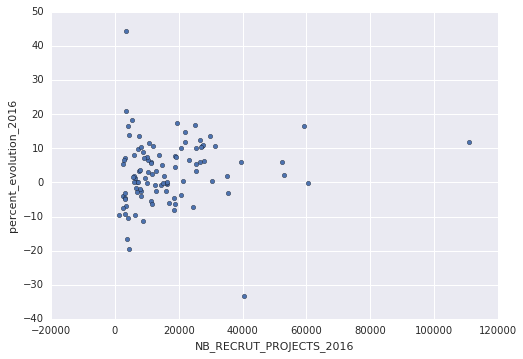

In [15]:
bmo_per_departement = bmo_evolution.groupby(['DEPARTEMENT_CODE', 'DEPARTEMENT_NAME']).sum()
bmo_per_departement['evolution_2016'] = bmo_per_departement.NB_RECRUT_PROJECTS_2016.div(bmo_per_departement.NB_RECRUT_PROJECTS_2015)
bmo_per_departement['percent_evolution_2016'] = (bmo_per_departement.evolution_2016 - 1) * 100
bmo_per_departement.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2016', y='percent_evolution_2016');

There are few outliers. Let's first check the départements with the most hiring to understand all the outliers on the right:

In [16]:
dimensions_2016 = ['percent_evolution_2016', 'NB_RECRUT_PROJECTS_2016']
bmo_per_departement.sort_values('NB_RECRUT_PROJECTS_2016', ascending=False)[dimensions_2016].head(8)

,,percent_evolution_2016,NB_RECRUT_PROJECTS_2016
DEPARTEMENT_CODE,DEPARTEMENT_NAME,,
75,PARIS,11.811170,110924.24
69,RHÔNE,-0.191864,60407.02
92,HAUTS-DE-SEINE,16.536260,59366.22
59,NORD,2.125901,52975.66
33,GIRONDE,5.975745,52327.69
13,BOUCHES-DU-RHÔNE,-33.289078,40446.01
44,LOIRE-ATLANTIQUE,5.935342,39503.54
31,HAUTE-GARONNE,-2.988355,35531.97


Obviously Paris is way bigger than the rest but still has a strong evolution (+11.8%). Then there is Hauts-de-Seine (just outside Paris, especially with "La Défense" district) which is big but really growing (+16.53%). And on the other side, Marseille is crashing (-33%).

Now let's check the extreme changes:

In [17]:
bmo_per_departement['absolute_percent_evolution_2016'] = bmo_per_departement.percent_evolution_2016.abs()
bmo_per_departement.sort_values('absolute_percent_evolution_2016', ascending=False)[dimensions_2016].head()

,,percent_evolution_2016,NB_RECRUT_PROJECTS_2016
DEPARTEMENT_CODE,DEPARTEMENT_NAME,,
971,GUADELOUPE,44.366767,3486.52
13,BOUCHES-DU-RHÔNE,-33.289078,40446.01
976,MAYOTTE,20.997473,3567.82
973,GUYANE,-19.467290,4500.60
53,MAYENNE,18.307822,5251.54


Weirdly Guadeloupe & Guyane (two oversee départements) have opposite but very strong changes. We could investigate a bit more if needed.

### Evolution by Job Family

Show the distribution of hiring growth and volumes for job families:

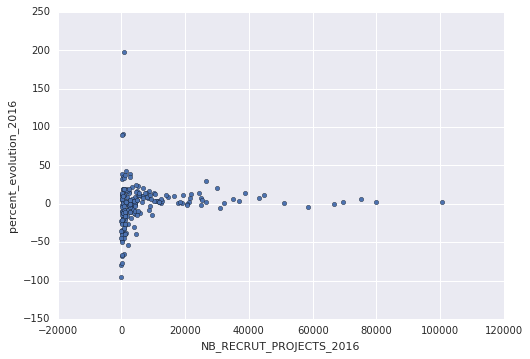

In [18]:
bmo_per_fap = bmo_evolution.groupby(['FAP_CODE', 'FAP_NAME']).sum()
bmo_per_fap['evolution_2016'] = bmo_per_fap.NB_RECRUT_PROJECTS_2016.div(bmo_per_fap.NB_RECRUT_PROJECTS_2015)
bmo_per_fap['percent_evolution_2016'] = (bmo_per_fap.evolution_2016 - 1) * 100
bmo_per_fap.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2016', y='percent_evolution_2016');

A first conclusion is that only job families with few hiring have huge evolutions. However let's look at the job family that almost got -100%.

In [19]:
bmo_per_fap.sort_values('percent_evolution_2016')[dimensions_2016].head()

,,percent_evolution_2016,NB_RECRUT_PROJECTS_2016
FAP_CODE,FAP_NAME,,
U1Z92,Écrivains,-94.889297,6.78
A3Z90,Cadres et maîtres d'équipage de la marine,-79.209320,27.45
U1Z93,Artistes plasticiens,-77.666653,61.28
E1Z43,"Autres ouvriers qualifiés en verre, céramique, métallurgie, matériaux de construction et énergie",-67.490604,256.53
W0Z80,Professeurs des écoles,-66.401160,346.67


So "writers" seems so 2015…

Let's check the distribution again only focusing on job families with more than 20k hires in the year:

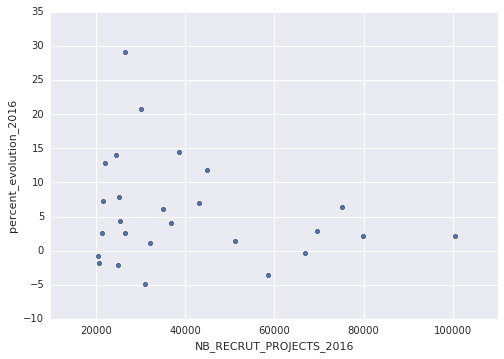

In [20]:
bmo_per_large_fap = bmo_per_fap[bmo_per_fap.NB_RECRUT_PROJECTS_2016 >= 20000]
bmo_per_large_fap.plot(kind='scatter', x='NB_RECRUT_PROJECTS_2016', y='percent_evolution_2016');

That looks reasonnable, let's check top growth:

In [21]:
bmo_per_large_fap.sort_values('percent_evolution_2016', ascending=False)[dimensions_2016].head()

,,percent_evolution_2016,NB_RECRUT_PROJECTS_2016
FAP_CODE,FAP_NAME,,
T3Z61,"Agents de sécurité et de surveillance (dont enquêteurs privés, agents cynophiles, convoyeurs de fonds)",29.095705,26482.16
M2Z90,"Ingénieurs et cadres d'études, R et D en informatique, chefs de projets informatiques",20.714902,30004.10
U1Z91,"Artistes (en musique, danse, spectacles, dont professeurs d'art)",14.489904,38630.45
L2Z61,"Agents administratifs divers (dont saisie, assistanat RH, enquêtes)",13.985598,24420.14
U1Z80,Professionnels des spectacles,12.868539,21935.26


It looks like Software Engineers with a lot of muscles are pretty trendy…

## Conclusion

So BMO 2016 data looks pretty good and after a quick clean-up we were able to compare it with the previous years (2014 & 2015).

Some high level insights can be deduced from comparing these datasets. For instance, hiring is crashing in Marseille whereas it's in really good shape in Paris, and in Paris' western suburbs. Also hiring is booming for Security Guards and Software Engineers.

Possible next steps:
* compare 2015 -> 2016 evolution with the evolution from 2014 -> 2015 (e.g. did Marseille had an exceptional year last year, or is it really declining?)
* go more local and understand at the "bassin d'emploi" level the local dynamics. E.g. find where a local decrease is compensated by a local increase next door so that we could advise our users to commute a bit more.
* compare flux and stock: the BMO is mixing new hires and replacements, but if we had a dataset with the number of currently employed persons we could distinguish local markets that are booming, and the ones that are becoming less stable (more hiring, but more firing as well).